# **Convolutional Neural Network to classify solar panels**

## **Step 1 : Building a dataloader for Kasmi et al. (2023)**

### The first part of this script builds a dataloader for  the Kasmi et al. (2023) dataset to train a CNN to detect solar panels 


### TO DO  ###

- [X] Créer un nouveau fichier .csv avec les annotations (uniquement pour les images google) et rentrer le lien dans le dataloader

- [ ] Copier le code sur Colab

- [ ] Comprendre plus en détail la définition de la classe CustomImageDataSet

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image

### 1) Label attribution ###

Nous allons faire de la classification binaire, on récupère donc les labels à partir des identifiants images et masques dans le jeu de données.

In [2]:
IGN_dataset = "/Users/lucius/Desktop/2A ENSAE/Projet Statapps/bdappv/ign/img"
annotations_file=pd.read_csv('/Users/lucius/Desktop/2A ENSAE/Projet Statapps/bdappv/metadata.csv')

In [3]:
pd.set_option('display.max_columns', None)
annotations_file.head()

,idInstallation,identifiant,idInverter,nameInverter,countInverters,idArrays,nameArrays,countArrays,surface,azimuth,typeInstallation,tilt,typeIntegration,kWp,departement,city,provider,selfConsumption,isIntegrated,dateInstalled,controlled,IGNControlled,GoogleControlled
0,1,OSIBG1RDEDJ,593,SMA - Sunny Boy 2800,1,2120,Sanyo - HIP-215 NKHE1,14,22.0,-20.0,1,20,INTERSOL D UBBINK,3010.0,31,Castanet-Tolosan,MECOTECH,True,True,2007-09-01,True,True,False
1,10,VTIOIAEQJEC,601,SMA - Sunny Boy 4200 TL,1,2121,Sanyo - HIP-215 NKHE5,20,25.0,-40.0,1,30,Intersol,4300.0,49,Saint-BarthÃ©lemy-d'Anjou,SIDEC,True,True,2007-09-01,True,True,False
2,1001,BWZEK3E9OJAOY,736,Sputnik - SOLARMAX 2000C,1,3110,Sunasol - SLMI140,15,15.0,180.0,1,25,tuiles PV,2100.0,69,DÃ©cines-Charpieu,SUNASOL/ Duvert Electricit&amp;eacute;,True,True,2007-12-01,True,False,False
3,1002,FEIKQ3EAGKXFB,256,Fronius - IG 30,1,2156,Schott - ASE-165-GT-FT/MC/170,18,23.0,10.0,1,20,int&eacute;gr&eacute,3060.0,30,Rousson,Eco - Energies,True,True,2008-09-01,True,False,False
4,1003,NDXQX3EBUEZNO,591,SMA - Sunny Boy 2500,1,1188,Biohaus - Biosol 180 P 50/6+,16,23.0,180.0,1,45,totale sur toit ardo,2880.0,35,AndouillÃ©-Neuville,EMRENN,True,True,2008-04-01,True,False,False


Le problème ici est que nous ne disposons pas de deux informations importantes : 
- A quelle dossier appartient quelle image? (IGN ou Google?)
- Comment splitter au hasard le training set du test set ?

In [4]:
annotations_file.shape

(28408, 23)

In [5]:
annotations_file['nameArrays'].value_counts()

Sanyo - HIP-214 NKHE5                                      965
Sanyo - HIP-210 NKHE1                                      674
Pas_dans_la_liste_panneaux - Pas_dans_la_liste_panneaux    389
SunPower - SPR-300-WHT-I                                   347
Schuco - MPE 200                                           292
                                                          ... 
Sunways - SM 215 M (215Wp)                                   1
SolarWorld - SW 196 vario poly                               1
Biohaus - Biosol 200M 50/6                                   1
Solon AG - M230 / 6+ (235W)                                  1
ALEO - aleo 200-6-XXL                                        1
Name: nameArrays, Length: 2551, dtype: int64

In [6]:
#création d'une fonction pour récupérer les noms d'un dossier

def f(path):
    dirs = os.listdir(path) #on définit le directory d'où on souhaite extraire le nom des fichiers
    return [file.replace('.png','') for file in dirs]

In [7]:
path_images_google = '/Users/lucius/Desktop/2A ENSAE/Projet Statapps/bdappv/google/img/'
path_images_ign = '/Users/lucius/Desktop/2A ENSAE/Projet Statapps/bdappv/ign/img/'
path_mask_google = '/Users/lucius/Desktop/2A ENSAE/Projet Statapps/bdappv/google/mask/'
path_mask_ign = '/Users/lucius/Desktop/2A ENSAE/Projet Statapps/bdappv/ign/mask/'


# On récupère tous les noms des images Google et IGN

images = f(path_images_google) + f(path_images_ign)
im_g = f(path_images_google)

# On récupère ensuite tous les noms des images Google et IGN ayant des masques
#En effet, certaines images Google contiennent des panneaux mais n'ont pas de masque 
#alors que leur équivalent IGN possède un masque, on doit donc leur attribuer le label '1' pour les classifier ensuite

im_mask_google = f(path_mask_google)
im_mask_ign = f(path_mask_ign)


#Google

#IGN

In [8]:
im = pd.DataFrame (images, columns = ['identifiant'])
im_mask_google = pd.DataFrame (im_mask_google, columns = ['identifiant'])
im_g = pd.DataFrame (im_g, columns = ['identifiant'])
im_mask_ign = pd.DataFrame (im_mask_ign, columns = ['identifiant'])

#On label '1' toutes les images comportant un masque et 0 sinon
im['Label'] = im['identifiant'].isin(im_mask_ign['identifiant'].append(im_mask_google['identifiant'])).astype(int)

im['Label'].value_counts() #on vérifie bien qu'on a des valeurs cohérentes 

#On label '1' toutes les images Google et '0' sinon
im['L_Google'] = im['identifiant'].isin(im_g['identifiant']).astype(int)

/var/folders/n5/3cv0cz914xgbz9ghnnt5my_c0000gn/T/ipykernel_70064/3565360278.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im['Label'] = im['identifiant'].isin(im_mask_ign['identifiant'].append(im_mask_google['identifiant'])).astype(int)


In [9]:
im['L_Google'].value_counts()  

1    46132
Name: L_Google, dtype: int64

In [10]:
#On ne garde que les images Google pour le moment

im = im.drop(im[im.L_Google<1].index) #on vire les images IGN sans équivalent Google

im['L_Google'].value_counts()  



1    46132
Name: L_Google, dtype: int64

In [11]:
#On sait que beaucoup d'images Google ont leur équivalent IGN (échelle différente) 
#on ne garde donc qu'un seul nom (comme sur le fichier metadata)

im = im.drop_duplicates() #On vire les images IGN qui avaient un équivalent Google
len(im) == im['identifiant'].nunique()


True

In [12]:
df = pd.merge(annotations_file, im, how="outer", on=["identifiant"]) #cette partie de script ne récupère que les noms déjà présents dans la base

## **Préparation du dataloader**

Pour cette partie, nous avons principalement repris la documentation PyTorch sur la programmation des DataLoaders, que l'on peut retrouver ici : https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [13]:
#On ne garde que l'identifiant et les labels
df= df[['identifiant', 'Label']]
df.head()
df['identifiant'] = df['identifiant'].astype(str) + '.png' #on rajoute les extensions pour que le dataloader récupère les fichiers
print(df)

              identifiant  Label
0         OSIBG1RDEDJ.png      1
1         VTIOIAEQJEC.png      1
2       BWZEK3E9OJAOY.png      1
3       FEIKQ3EAGKXFB.png      1
4       NDXQX3EBUEZNO.png      1
...                   ...    ...
28802  DUOXU9E64AFPUA.png      0
28803  TNQQBA1A4YVAMB.png      0
28804  NTZODA2F3EZHCE.png      0
28805  WKCKWA22FMMJXV.png      0
28806  NIQUNA293VFZNT.png      0

[28807 rows x 2 columns]


Ici on doit déjà préparer la différence entre dataset d'entrainement et dataset de test pour faire deux instanciations différentes de la classe dataset, par conséquent on va diviser de façon équilibrée le dataset en training et test datasets.

In [38]:
#On sépare le dataset en un training dataset et un test dataset avec sci-kit learn
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)



On va maintenant créer la classe qui va nous permettre d'importer facilement les images pour entrainer notre réseau de neurones.

In [40]:
#Codage du dataloader à la main

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Dans notre cas, on réimporte les données des panneaux solaires.


In [49]:
#annot = "/Users/lucius/Desktop/label_google.csv"
training_data = "/Users/lucius/Desktop/train_data.csv"
test_data = "/Users/lucius/Desktop/test_data.csv"

#dataset = CustomImageDataset(annot,path_images_google)

training_data = CustomImageDataset(training_data,path_images_google)
test_data = CustomImageDataset(test_data,path_images_google)
# Create a data loader to iterate over the dataset
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 400, 400])


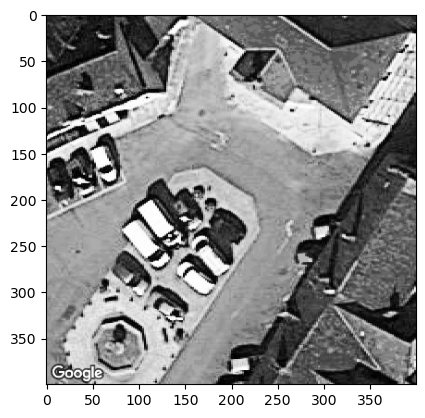

Label: 0


In [52]:
# Display image and label.

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")